# Running delay filter, followed by xrfi

In [19]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import os
from hera_cal.delay_filter import Delay_Filter
from hera_cal.data import DATA_PATH
from pyuvdata import UVData
import shutil
from hera_qm import xrfi
from hera_qm import utils as qm_utils
from hera_cal import io
import copy

## Read Data

Load data by creating a `Delay_Filter` object and then reading in some data.

In [20]:
dfil = Delay_Filter()
fname = os.path.join(DATA_PATH, "zen.2458043.12552.xx.HH.uvORA")
uv = UVData()
uv.read_miriad(fname)
dfil.load_data(uv)
uv_raw = copy.deepcopy(uv)  # For comparing later

## Perform Delay Filter

In [21]:
dfil.run_filter()

## Update UVData object

In [22]:
io.update_uvdata(dfil.input_data, data=dfil.filtered_residuals)

## Run xrfi

In [23]:
# Construct arg parser
a = qm_utils.get_metrics_ArgumentParser('xrfi_run')
# Here are some example arguments. There are others too - check hera_qm.utils
arg0 = "--infile_format=miriad"
arg1 = "--xrfi_path={}".format(os.path.join(DATA_PATH, 'test_output'))
arg2 = "--algorithm=xrfi"
arg3 = "--kt_size=2"
arg4 = "--kf_size=2"
arg5 = "--sig_init=6"
arg6 = "--sig_adj=2"
arg7 = "--summary"
arg8 = "--model_file={}".format(os.path.join(DATA_PATH, 'zen.2458043.12552.xx.HH.uvA.vis.uvfits'))
arg9 = "--calfits_file={}".format(os.path.join(DATA_PATH, 'zen.2458043.12552.xx.HH.uvORA.abs.calfits'))
arguments = ' '.join([arg0, arg1, arg2, arg3, arg4, arg5, arg6, arg7, arg8, arg9])
cmd = ' '.join([arguments, fname])
args = a.parse_args(cmd.split())

xrfi.xrfi_run(dfil.input_data, args, cmd)

## Apply to data

In [24]:
# Construct new arg parser
a = qm_utils.get_metrics_ArgumentParser('xrfi_apply')
arg0 = "--infile_format=miriad"
arg1 = "--outfile_format=miriad"
arg2 = "--extension=R"
arg3 = "--xrfi_path={}".format(os.path.join(DATA_PATH, 'test_output'))
flag_file = os.path.join(DATA_PATH, 'test_output', 'zen.2458043.12552.xx.HH.uvORA.flags.npz')
arg4 = "--flag_file=" + flag_file
wf_file1 = os.path.join(DATA_PATH, 'test_output', 'zen.2458043.12552.xx.HH.uvORA.abs.calfits.g.flags.npz')
wf_file2 = os.path.join(DATA_PATH, 'test_output', 'zen.2458043.12552.xx.HH.uvORA.abs.calfits.x.flags.npz')
# Note the x-flags from this file result in all flags, but this is how you'd do it.
arg5 = "--waterfalls=" + wf_file1 # + "," + wf_file2
arg6 = "--overwrite"  # Overwrite test files
arguments = ' '.join([arg0, arg1, arg2, arg3, arg4, arg5, arg6])
cmd = ' '.join([arguments, fname])
args = a.parse_args(cmd.split())

xrfi.xrfi_apply(args.filename, args, cmd)

File exists: clobbering


In [25]:
uvR = UVData()
uvR.read_miriad(os.path.join(DATA_PATH, 'test_output', os.path.basename(fname) + args.extension))

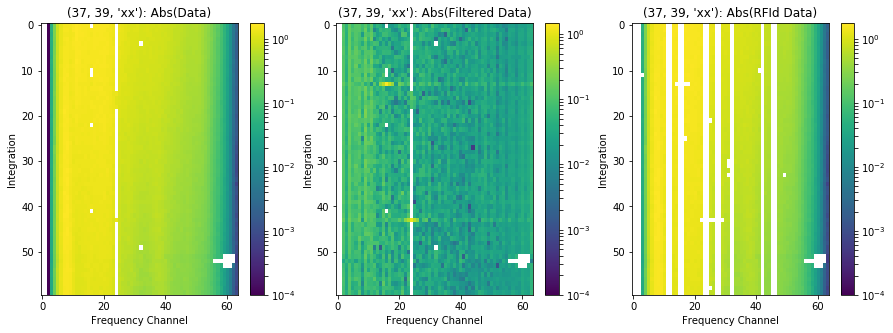

In [27]:
bl = (37, 39, 'xx')
plt.figure(figsize=(15,5))
plt.subplot(131)
d = uv_raw.get_data(bl)
f = uv_raw.get_flags(bl)
d = np.ma.masked_where(f, d)
plt.imshow(np.abs(d), aspect='auto', norm=colors.LogNorm(vmin=1e-4))
plt.colorbar()
plt.title(str(bl) + ': Abs(Data)')
plt.xlabel('Frequency Channel')
plt.ylabel('Integration')

plt.subplot(132)
res = dfil.filtered_residuals[bl]
res[dfil.flags[bl]] = 0
plt.imshow(np.abs(res), aspect='auto', norm=colors.LogNorm(vmin=1e-4))
plt.colorbar()
plt.title(str(bl) + ': Abs(Filtered Data)')
plt.xlabel('Frequency Channel')
plt.ylabel('Integration')

plt.subplot(133)
d = uvR.get_data(bl)
f = uvR.get_flags(bl)
d = np.ma.masked_where(f, d)
plt.imshow(np.abs(d), aspect='auto', norm=colors.LogNorm(vmin=1e-4))
plt.colorbar()
plt.title(str(bl) + ': Abs(RFId Data)')
plt.xlabel('Frequency Channel')
plt.ylabel('Integration')